Mục đích: load lại X_train, X_test, y_train, y_test và logistic model từ Note 02 (ở đây train lại để minh hoạ, vì ta chưa lưu model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression

PROC_DIR = Path("../data/processed")

# load lại dữ liệu
X_train = pd.read_csv(PROC_DIR / "X_train.csv", index_col=0)
X_test  = pd.read_csv(PROC_DIR / "X_test.csv", index_col=0)
y_train = pd.read_csv(PROC_DIR / "y_train.csv", index_col=0)["status"]
y_test  = pd.read_csv(PROC_DIR / "y_test.csv", index_col=0)["status"]

# đọc tên cột sau OHE
featnames_path = PROC_DIR / "feature_names.txt"
feature_names = [ln.strip() for ln in open(featnames_path, "r", encoding="utf-8").read().splitlines()]

# train lại logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

Mục đích: xem coef (hệ số hồi quy), odds ratio = e^(coef) để giải thích tác động

In [2]:
coef = logreg.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("coef", ascending=False)

coef_df.head(10)


,feature,coef,odds_ratio
16,ssc_p,1.852987,6.378843
18,degree_p,1.095345,2.990214
17,hsc_p,0.904111,2.469735
13,workex_Yes,0.846709,2.331960
9,degree_t_Comm&Mgmt,0.644774,1.905557
1,gender_M,0.501033,1.650426
3,ssc_b_Others,0.344253,1.410935
6,hsc_s_Arts,0.309199,1.362334
4,hsc_b_Central,0.129400,1.138145
14,specialisation_Mkt&Fin,0.057360,1.059037


Mục đích: trực quan top yếu tố dương (tăng khả năng được tuyển) & âm (giảm khả năng)

C:\Users\nguye\AppData\Local\Temp\ipykernel_25848\3589862078.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


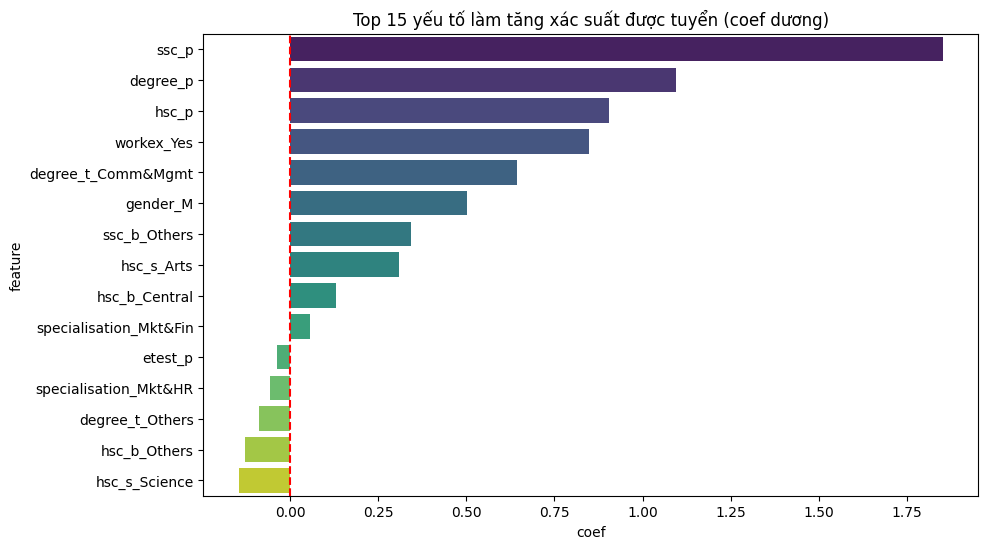

C:\Users\nguye\AppData\Local\Temp\ipykernel_25848\3589862078.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


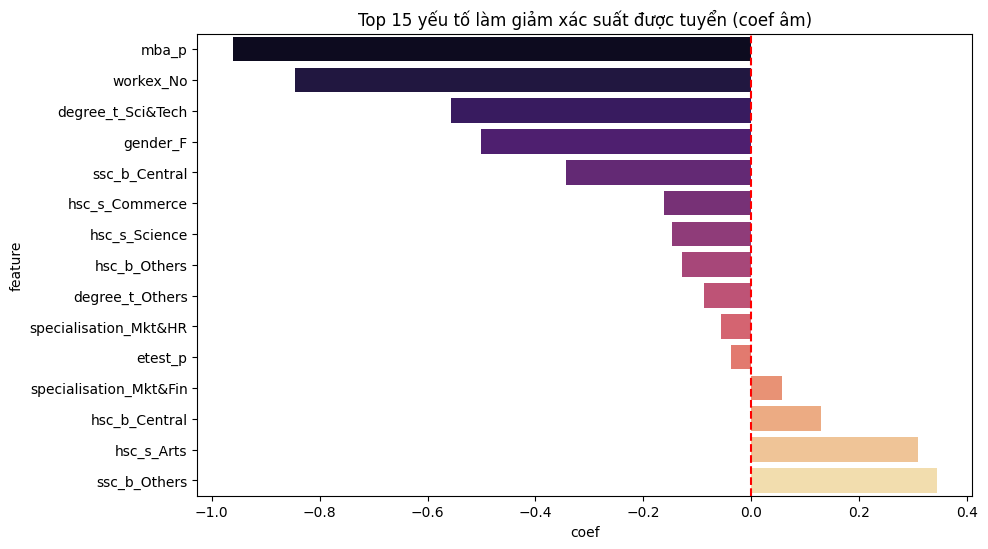

In [3]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.sort_values("coef", ascending=False).head(15),
    x="coef", y="feature", palette="viridis"
)
plt.title("Top 15 yếu tố làm tăng xác suất được tuyển (coef dương)")
plt.axvline(0, color="red", linestyle="--")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.sort_values("coef", ascending=True).head(15),
    x="coef", y="feature", palette="magma"
)
plt.title("Top 15 yếu tố làm giảm xác suất được tuyển (coef âm)")
plt.axvline(0, color="red", linestyle="--")
plt.show()


Mục đích: trực quan năng lực phân loại, giải thích trade-off precision/recall

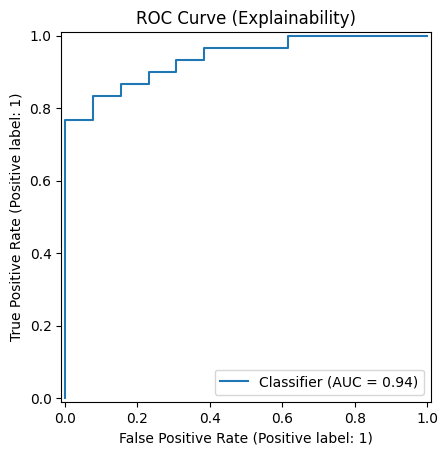

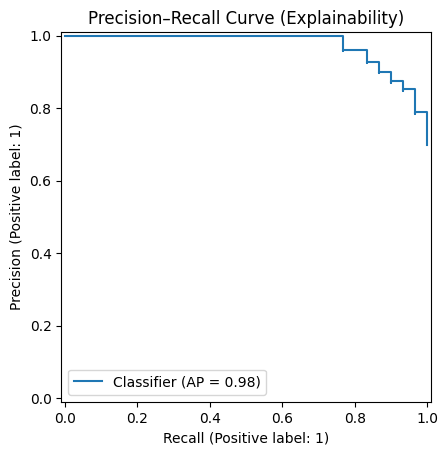

In [4]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

y_score = logreg.predict_proba(X_test)[:,1]

RocCurveDisplay.from_predictions(y_test, y_score)
plt.title("ROC Curve (Explainability)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_score)
plt.title("Precision–Recall Curve (Explainability)")
plt.show()


Mục đích: xem cụ thể yếu tố tăng/giảm khả năng được tuyển (đọc bảng dễ hơn)

In [5]:
# odds ratio > 1: tăng xác suất
# odds ratio < 1: giảm xác suất
coef_df["interpretation"] = np.where(
    coef_df["odds_ratio"] > 1,
    "Tăng khả năng được tuyển",
    "Giảm khả năng được tuyển"
)

coef_df.sort_values("odds_ratio", ascending=False).head(10)


,feature,coef,odds_ratio,interpretation
16,ssc_p,1.852987,6.378843,Tăng khả năng được tuyển
18,degree_p,1.095345,2.990214,Tăng khả năng được tuyển
17,hsc_p,0.904111,2.469735,Tăng khả năng được tuyển
13,workex_Yes,0.846709,2.331960,Tăng khả năng được tuyển
9,degree_t_Comm&Mgmt,0.644774,1.905557,Tăng khả năng được tuyển
1,gender_M,0.501033,1.650426,Tăng khả năng được tuyển
3,ssc_b_Others,0.344253,1.410935,Tăng khả năng được tuyển
6,hsc_s_Arts,0.309199,1.362334,Tăng khả năng được tuyển
4,hsc_b_Central,0.129400,1.138145,Tăng khả năng được tuyển
14,specialisation_Mkt&Fin,0.057360,1.059037,Tăng khả năng được tuyển


Mục đích: minh họa local explainability cho vài sinh viên cụ thể

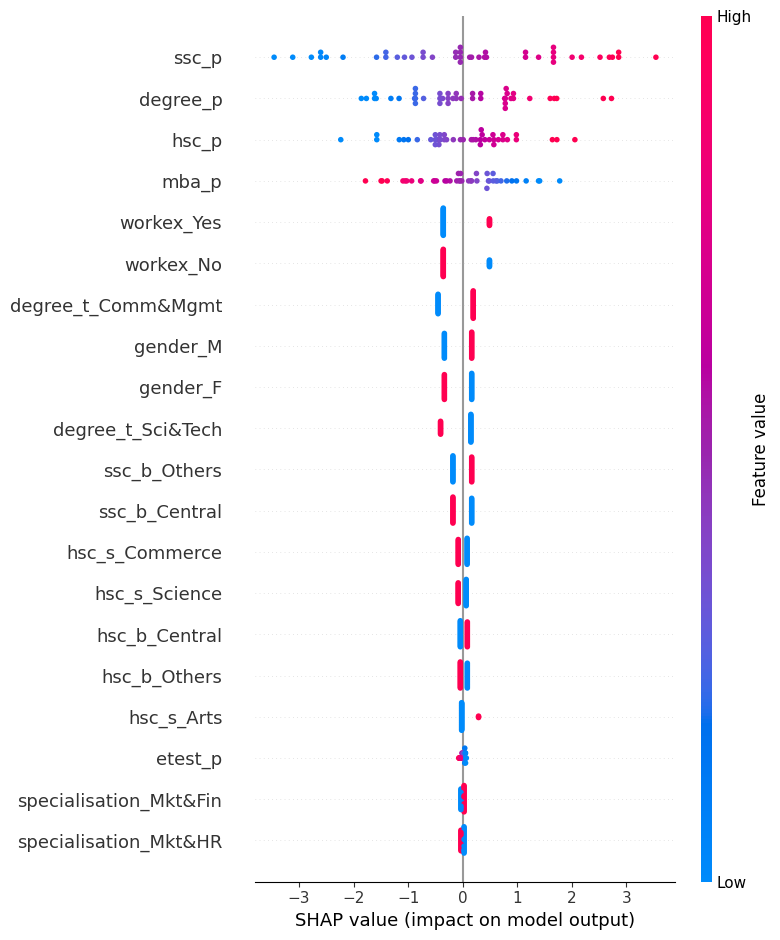

In [7]:
# nếu muốn cài shap:
# !pip install shap
import shap

explainer = shap.LinearExplainer(logreg, X_train, feature_names=feature_names)
shap_values = explainer.shap_values(X_test)

# vẽ summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
